In [27]:
import pandas as pd
import requests
import warnings
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
# Suppress specific warnings
warnings.filterwarnings("ignore", category=xr.coding.times.SerializationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
# Path to the text file
file_path = r"C:\Users\daddy\Downloads\SurfaceTemp_Giss_NASA.txt"

# Initialize lists to store data
years = []
no_smoothing = []
lowess_5 = []

# Read the text file and process each line
with open(file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith('-') or line.startswith('Year'):
            continue
        columns = line.split()
        if len(columns) == 3:
            years.append(int(columns[0]))
            no_smoothing.append(float(columns[1]))
            lowess_5.append(float(columns[2]))

# Create a DataFrame from the extracted data
df = pd.DataFrame({'Year': years, 'No_Smoothing': no_smoothing, 'Lowess(5)': lowess_5})

# Load World Population data
file_path2 = r"C:\Users\daddy\Downloads\WorldPopulation.csv"
df2 = pd.read_csv(file_path2)

# Fetch JSON data for sunspot cycles from NOAA
url = "https://services.swpc.noaa.gov/json/solar-cycle/observed-solar-cycle-indices.json"
response = requests.get(url)
if response.status_code == 200:
    data = response.json()
    df3 = pd.DataFrame(data)
    df3.rename(columns={df3.columns[0]: 'Year'}, inplace=True)
    df3['Year'] = pd.to_datetime(df3['Year'], format='%Y-%m')
    df_filtered = df3[df3['Year'].dt.month == 12]
    last_row = df3.iloc[-1:].copy()
    df3 = pd.concat([df_filtered, last_row])
    df3['Year'] = df3['Year'].dt.year
else:
    print("Failed to retrieve data:", response.status_code)

# Load Atmospheric CO₂ Concentrations data
df4 = pd.read_csv(r"C:\Users\daddy\Downloads\Atmospheric_CO₂_Concentrations.csv")

# Load the NetCDF file for TSI data
file_path = r"C:\Users\daddy\Downloads\tsi_v02r01_yearly_s1610_e2023_c20240221.nc"
ds = xr.open_dataset(file_path, decode_times=True)
df5 = ds.to_dataframe()
df5.drop_duplicates(inplace=True)
df5.reset_index(inplace=True)

# Clean up time columns in df5
actual_time_column = 'time'
actual_time_column2 = 'time_bnds'
if actual_time_column in df5.columns:
    df5[actual_time_column] = df5[actual_time_column].astype(str).str.replace(r'-07-01 00:00:00', '')
else:
    print(f"Column '{actual_time_column}' not found in DataFrame")
if actual_time_column2 in df5.columns:
    df5[actual_time_column2] = df5[actual_time_column2].astype(str).str.replace(r'-01-01 00:00:00', '')
else:
    print(f"Column '{actual_time_column2}' not found in DataFrame")

# Convert 'time' column to year
df5['year'] = df5[actual_time_column2].astype(int)
df5 = df5[df5['year'] >= 1970]

# Load Volcanic Activity data from the Smithsonian which was webscraped into an empty csv file
df6 = pd.read_csv(r"C:\Users\daddy\Downloads\Untitled spreadsheet - Untitled spreadsheet - Sheet1 (1).csv")
df6 = df6.drop(index=1)
columns_to_drop = ['Year Url', 'VEI <= 2', 'VEI 3', 'VEI 4', 'VEI 5', 'VEI 6']
df6 = df6.drop(columns=columns_to_drop)
# Clean df4
df4['Date'] = df4['Date'].astype(str)
df4 = df4[df4['Date'].str.endswith('M12')]
df4 = df4[df4['Unit'] != 'Parts Per Million']
df4['Date'] = df4['Date'].str.replace(r'M\d{2}', '', regex=True)
# Convert Year columns to string type for relevant cases
df['Year'] = df['Year'].astype(str)
df2['Year'] = df2['Year'].astype(str)
df3['Year'] = df3['Year'].astype(str)
# Filter dataframes to start from 1970
df = df[df['Year'].str[:4].astype(int) >= 1969]
df2 = df2[df2['Year'].str[:4].astype(int) >= 1969]
df3 = df3[df3['Year'].str[:4].astype(int) >= 1969]
# Rename time columns that dont have the name 'Year' to Year
df4.rename(columns={' Date': 'Year'}, inplace=True)
df5.rename(columns={'time': 'Year'}, inplace=True)
# Sort df2 by year so that it has the same order as the Esrths Surface Temperature column
df2 = df2.sort_values(by='Year').reset_index(drop=True)
# Clean df2 columns
df2['Yearly Change'] = df2['Yearly Change'].str.replace('%', '')
df2['World Population'] = df2['World Population'].str.replace(',', '')
df2['Net Change'] = df2['Net Change'].str.replace(',', '')
# Convert dataframes to float in relevant cases
df = df.astype(float)
df2 = df2.astype(float)
df3 = df3.astype(float)
# Calculate percentage changes to generate stationary representations of each Variable
df['No Smoothing Change'] = df['No_Smoothing'].pct_change() * 100
df2['World Population Change'] = df2['World Population'].pct_change() * 100
df3['ssn Change'] = df3['ssn'].pct_change() * 100
df4['Carbon Emission Change'] = df4['Value'].pct_change() * 100
df5['TSI Change'] = df5['TSI'].pct_change() * 100
df6['Eruptions Total Change'] = df6['Eruptions Total'].pct_change() * 100
# Limit df4 to numeric columns
df4 = df4[['Value', 'Carbon Emission Change', 'Date']]
df4.rename(columns={'Date': 'Year'}, inplace=True)
# Sort df6 by Year
df6 = df6.sort_values(by='Year', ascending=True)
df6 = df6[df6['Year'] >= 1970]
# Convert Year columns back to integer type
df['Year'] = df['Year'].astype(int)
df2['Year'] = df2['Year'].astype(int)
df3['Year'] = df3['Year'].astype(int)
df4['Year'] = df4['Year'].astype(int)
df5['Year'] = df5['Year'].astype(int)
df6['Year'] = df6['Year'].astype(int)
# Remove the first row from dataframes to start from 1970
df = df.iloc[1:]
df2 = df2.iloc[1:]
df3 = df3.iloc[1:]
df4 = df4.iloc[11:]
df5 = df5.iloc[1:]
# Drop duplicates in the Year column of df5
df5 = df5.drop_duplicates(subset='Year', keep='first')
# Reset index for all dataframes in order to ensure accurate calculations later
df.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)
df3.reset_index(drop=True, inplace=True)
df4.reset_index(drop=True, inplace=True)
df5.reset_index(drop=True, inplace=True)
df6.reset_index(drop=True, inplace=True)
#Print out each dataframe
df, df2, df3, df4, df5, df6, df7

(    Year  No_Smoothing  Lowess(5)  No Smoothing Change
 0   1970          0.03      -0.00           -40.000000
 1   1971         -0.08       0.00          -366.666667
 2   1972          0.01       0.00          -112.500000
 3   1973          0.16      -0.00          1500.000000
 4   1974         -0.07       0.01          -143.750000
 5   1975         -0.01       0.02           -85.714286
 6   1976         -0.10       0.04           900.000000
 7   1977          0.18       0.07          -280.000000
 8   1978          0.07       0.12           -61.111111
 9   1979          0.16       0.16           128.571429
 10  1980          0.26       0.20            62.500000
 11  1981          0.32       0.21            23.076923
 12  1982          0.14       0.22           -56.250000
 13  1983          0.31       0.21           121.428571
 14  1984          0.16       0.21           -48.387097
 15  1985          0.12       0.22           -25.000000
 16  1986          0.18       0.24            50

The hypothesis for this analysis is that the solar cycles of sunspot activity on the surface of the Sun can be a larger predictor of Earths' Surface temperature than Human carbon emissions in a stationary environment.

In [28]:
#Displaying the lengths of each dataframe
len(df), len(df2), len(df3), len(df4), len(df5), len(df6), len(df7)

(54, 54, 55, 54, 54, 55, 34)

In [4]:
#Combining all the Percentage Change columns into one dataframe
combined_df = pd.DataFrame({
    'Earth Surface Temperature Percentage Change': df['No Smoothing Change'],
    'World Population Percentage Change': df2['World Population Change'],
    'Carbon Emission Percentage Change': df4['Carbon Emission Change'],
    'Sun Spot Number Percentage Change': df3['ssn Change'],
    'Total Solar Irradiance Percentage Change': df5['TSI Change'],
    'Eruptions Total Change': df6['Eruptions Total Change'],
})
combined_df = combined_df.dropna(axis=0)
combined_df.head()

,Earth Surface Temperature Percentage Change,World Population Percentage Change,Carbon Emission Percentage Change,Sun Spot Number Percentage Change,Total Solar Irradiance Percentage Change,Eruptions Total Change
0,-40.000000,2.064131,-18.421053,-14.718615,-0.000089,1.785714
1,-366.666667,2.023406,-12.903226,-1.438240,-0.024664,1.818182
2,-112.500000,1.979697,74.074074,-44.806867,0.004423,-20.289855
3,1500.000000,1.962406,-29.787234,-48.211509,-0.017297,7.812500
4,-143.750000,1.919917,-12.121212,-11.111111,-0.006890,23.076923


In [32]:
# Normalize the columns for the Percentage Change data in a standard manner for simplicity
scaler = StandardScaler()
normalized_df = scaler.fit_transform(combined_df)
# Separate and identify the target column
target_column = normalized_df[:, 0]  # 'No Smoothing Change'
# A Function to calculate correlation for each feature against the target column
def calculate_correlation(feature, target):
    correlation_matrix = np.corrcoef(feature, target)
    correlation = correlation_matrix[0, 1]
    return correlation
# Calculating the correlation for each column with respect to the first column
correlations = {}
for i, column in enumerate(combined_df.columns[1:], start=1):  # Skip the first column as that is redundant
    correlations[column] = calculate_correlation(normalized_df[:, i], target_column)
# Output the correlations each percentage change column has with the Percentage Change of the Earths' Surface Temperature
for column, correlation in correlations.items():
    print(f"Correlation for '{column}' with respect to 'Earths Surface Temperature's Percentage Change': {correlation:.4f}")

Correlation for 'World Population Percentage Change' with respect to 'Earths Surface Temperature's Percentage Change': 0.1363
Correlation for 'Carbon Emission Percentage Change' with respect to 'Earths Surface Temperature's Percentage Change': -0.1160
Correlation for 'Sun Spot Number Percentage Change' with respect to 'Earths Surface Temperature's Percentage Change': -0.0254
Correlation for 'Total Solar Irradiance Percentage Change' with respect to 'Earths Surface Temperature's Percentage Change': -0.0676
Correlation for 'Eruptions Total Change' with respect to 'Earths Surface Temperature's Percentage Change': -0.0780


We can see here that at face value, the percentage change of the World Population is 13.6%.
Which is not strong at all but ironically the highest of all the columns. 
But take this with a grain of salt as we are going to see later. 

In [33]:
#Combining all the absolute measurement values of the data into one dataframe.
combined_df2 = pd.DataFrame({
    'Earth Surface Temp Absolute': df['No_Smoothing'],
    'World Population Absolute': df2['World Population'],
    'Carbon Emission Absolute': df4['Value'],
    'Sun Spot Number Absolute': df3['ssn'],
    'Total Solar Irradiance': df5['TSI'],
    'Volcanic Eruptions Total Absolute': df6['Eruptions Total'],
})
combined_df2 = combined_df2.dropna(axis=0)
combined_df2.head()

,Earth Surface Temp Absolute,World Population Absolute,Carbon Emission Absolute,Sun Spot Number Absolute,Total Solar Irradiance,Volcanic Eruptions Total Absolute
0,0.03,3.695390e+09,0.31,118.2,1361.375854,57.0
1,-0.08,3.770163e+09,0.27,116.5,1361.040039,56.0
2,0.01,3.844801e+09,0.47,64.3,1361.100220,55.0
3,0.16,3.920252e+09,0.33,33.3,1360.864746,69.0
4,-0.07,3.995517e+09,0.29,29.6,1360.770996,64.0


In [34]:
# Normalize the columns
scaler = StandardScaler()
normalized_df2 = scaler.fit_transform(combined_df2)

# Separate the target column
target_column2 = normalized_df2[:, 0]  # 'No Smoothing Change'
# Function to calculate correlation for each feature against the target column
def calculate_correlation(feature, target):
    correlation_matrix = np.corrcoef(feature, target)
    correlation2 = correlation_matrix[0, 1]
    return correlation2
# Calculate correlation for each column with respect to the first column
correlations2 = {}
for i, column2 in enumerate(combined_df2.columns[1:], start=1):  # Skip the first column
    correlations2[column2] = calculate_correlation(normalized_df2[:, i], target_column2)

# Output the correlations
for column2, correlation2 in correlations2.items():
    print(f"Correlation for '{column2}' with respect to 'Earths Surface Temperature': {correlation2:.4f}")

Correlation for 'World Population Absolute' with respect to 'Earths Surface Temperature': 0.9521
Correlation for 'Carbon Emission Absolute' with respect to 'Earths Surface Temperature': 0.6510
Correlation for 'Sun Spot Number Absolute' with respect to 'Earths Surface Temperature': -0.1763
Correlation for 'Total Solar Irradiance' with respect to 'Earths Surface Temperature': 0.0444
Correlation for 'Volcanic Eruptions Total Absolute' with respect to 'Earths Surface Temperature': 0.7220


Now as far as the absolute values go, We can see this MASSIVE 95% correlation the World Population has, While The totality of Volcanic Eruptions has a roughly 72% correlation and Human carbon emissions sitting at around a 65% correlation. 
But notice how the number of sunspots and total solar irradiance have remained with relatively low and weak linear relationships with the surface temperature of the Earth BOTH in stationary and non-stationary analysis.

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Normalize the columns
scaler = StandardScaler()
normalized_df = scaler.fit_transform(combined_df)

# Separate the target column
target_column = normalized_df[:, 0]  # 'No Smoothing Change'

# Function to calculate explained variance for each feature against the target column
def explained_variance(feature, target):
    combined_data = pd.DataFrame({'feature': feature, 'target': target})
    pca = PCA(n_components=1)
    pca.fit(combined_data)
    return pca.explained_variance_ratio_[0]

# Calculate explained variance for each column with respect to the first column
explained_variances = {}
for i, column in enumerate(combined_df.columns[1:], start=1):  # Skip the first column
    explained_variances[column] = explained_variance(normalized_df[:, i], target_column)
# Output the explained variances
for column, variance in explained_variances.items():
    print(f"Explained variance ratio for '{column}' with respect to 'Earth Surface Temperature Percentage Change': {variance:.4f}")

Explained variance ratio for 'World Population Percentage Change' with respect to 'Earth Surface Temperature Percentage Change': 0.5681
Explained variance ratio for 'Carbon Emission Percentage Change' with respect to 'Earth Surface Temperature Percentage Change': 0.5580
Explained variance ratio for 'Sun Spot Number Percentage Change' with respect to 'Earth Surface Temperature Percentage Change': 0.5127
Explained variance ratio for 'Total Solar Irradiance Percentage Change' with respect to 'Earth Surface Temperature Percentage Change': 0.5338
Explained variance ratio for 'Eruptions Total Change' with respect to 'Earth Surface Temperature Percentage Change': 0.5390


We now can see that the explained variance ratios for all the Percentage change columns are 50%+ and do not deviate much from one another telling us that each variable essentially is capable of explaining just over 50% of the variance in the values of the surface temperature of the Earths

In light of this, It is obvious we are clearly not seeing the full picture from just correlation and explained variance alone, ultimately we want to figure which of the columns represent the greatest ability to predict Earths' surface temperature.. As we can assume whichever variable is best able to predict the target is likely the largest cause of the change in the target.

We will begin with the percnetage change data

In [21]:
# A Function to calculate cross-correlation for a given lag
def calc_cross_correlation(column, target, lag):
    shifted_column = np.roll(column.values, lag)
    return np.corrcoef(shifted_column, target.values)[0, 1]

# Calculating the cross-correlation between the Percentage Change of the Earths' surface temperature and all other columns
correlations = combined_df.drop('Earth Surface Temperature Percentage Change', axis=1).apply(
    lambda x: x.corr(combined_df['Earth Surface Temperature Percentage Change']))

# Calculating the lagged correlations for a range of lags (-10 to 10) between the Percentage Change of the Earths' surface temperature and other columns
max_lag = 10
lagged_correlations = pd.DataFrame(index=range(-max_lag, max_lag + 1), columns=combined_df.columns[1:])
target = combined_df['Earth Surface Temperature Percentage Change']

for column in combined_df.columns[1:]:
    for lag in range(-max_lag, max_lag + 1):
        lagged_correlations.loc[lag, column] = calc_cross_correlation(combined_df[column], target, lag)

# Finding the maximum correlations and corresponding lags
max_correlations = lagged_correlations.max()
max_lags = lagged_correlations.idxmax()

# Outputting the results
print("Max Cross-Correlations:")
print(correlations)
print("\nMax Lagged Correlations:")
print(max_correlations)
print("\nCorresponding Lags:")
print(max_lags)

Max Cross-Correlations:
World Population Percentage Change          0.136290
Carbon Emission Percentage Change          -0.115974
Sun Spot Number Percentage Change          -0.025379
Total Solar Irradiance Percentage Change   -0.067573
Eruptions Total Change                     -0.078030
dtype: float64

Max Lagged Correlations:
World Population Percentage Change          0.330419
Carbon Emission Percentage Change           0.429052
Sun Spot Number Percentage Change           0.496642
Total Solar Irradiance Percentage Change    0.222511
Eruptions Total Change                      0.484652
dtype: object

Corresponding Lags:
World Population Percentage Change           3
Carbon Emission Percentage Change          -10
Sun Spot Number Percentage Change            7
Total Solar Irradiance Percentage Change     4
Eruptions Total Change                      -1
dtype: int64


When we look at cross correlations, again we can conclude that the Percentage Change of the Sunspot Numbers have a lower cross-correlation with Percentage Change of the Earths surface temperature compared to the others. This means that, on average, changes in sunspot numbers are less directly related to changes in temperature when looking at the data without considering time shifts. This is a very flawed way to look at the data as the relationship between the sun and Earth is cyclical. So to get an accurate perspective on how strongly the solar cycles effect the surface temperature of the Earth, we calculate the lagged correlations. 

The lagged correlations really give us an entirely new perspective on which variable is probably the best to make a model to predict the temperature of the surface of the Earth. The lagged correlations show that the highest predictability of Earths' surface temperature actually comes from a lagged value of 7 years in the percentage change sun spot variable.. Meaning a 7 year solar cycle has a larger potential to accurately predict the surface temperature of the Earth than any of the other columns at 49%.. Completely flipping the script on Volcanic Activity, Human Carbon Emissions and World Population.

We now see that the relationship between world population percentage changes and Earth's surface temperature is strongest when considering a delay of 3 years but ONLY at a correlation of 33%. While the relationship between carbon emission percentage changes and Earth's surface temperature is strongest with a lag of -10 years at 42%. This negative lag suggests that the effects of carbon emissions on temperature might be more complex and potentially not directly linked with Earths' surface temperature in a linear manner. 

We conclude from this that the Percentage Change of Sunspots on the sun are actually superior in predicting the surface temperature of the Earth than Human Carbon Emissions, World population AND volcanic eruptions as it sustains a higher correlation at a higher lag than any of the other columns. Which also explains why so many are quick to jump to the conclusions that world population and human carbon emissions have the strongest linear relationships with global warming instead of solar cycle related activities because we see that on average it takes about 7 years for changes in the number of sunspots on the surface of the sun to heavily effect the Earth. 

In [26]:
# Function to calculate cross-correlation for a given lag
def calc_cross_correlation(column, target2, lag):
    shifted_column = np.roll(column.values, lag)
    return np.corrcoef(shifted_column, target2.values)[0, 1]

# Calculate cross-correlation
correlations2 = combined_df2.drop('Earth Surface Temp Absolute', axis=1).apply(
    lambda x: x.corr(combined_df2['Earth Surface Temp Absolute']))

# Calculate lagged correlations for a range of lags (e.g., -10 to 10)
max_lag = 10
lagged_correlations2 = pd.DataFrame(index=range(-max_lag, max_lag + 1), columns=combined_df2.columns[1:])
target2 = combined_df2['Earth Surface Temp Absolute']

for column2 in combined_df2.columns[1:]:
    for lag in range(-max_lag, max_lag + 1):
        lagged_correlations2.loc[lag, column2] = calc_cross_correlation(combined_df2[column2], target2, lag)

# Find maximum correlations and corresponding lags
max_correlations2 = lagged_correlations2.max()
max_lags2 = lagged_correlations2.idxmax()

# Output the results
print("Max Cross-Correlations:")
print(correlations2)
print("\nMax Lagged Correlations:")
print(max_correlations2)
print("\nCorresponding Lags:")
print(max_lags2)

Max Cross-Correlations:
World Population Absolute            0.952054
Carbon Emission Absolute             0.651008
Sun Spot Number Absolute            -0.176289
Total Solar Irradiance               0.044362
Volcanic Eruptions Total Absolute    0.721968
dtype: float64

Max Lagged Correlations:
World Population Absolute            0.952054
Carbon Emission Absolute             0.651008
Sun Spot Number Absolute             0.079851
Total Solar Irradiance               0.044362
Volcanic Eruptions Total Absolute    0.725768
dtype: object

Corresponding Lags:
World Population Absolute            0
Carbon Emission Absolute             0
Sun Spot Number Absolute             9
Total Solar Irradiance               0
Volcanic Eruptions Total Absolute    1
dtype: int64


Now when viewing the Absolute values.. We will again see this non-stationary unambiguity where the absolute values show World Population, Volcanic Activity and Carbon Emission are the best predictors in a non-stationary dataset. However when we predict timeseries data it is MOST beneficial to utilize stationary variables which we proved above that the distributions of sun spot numbers on the surface of the sun is the BEST of ALL options to predict the surface temperature of the Earth. 

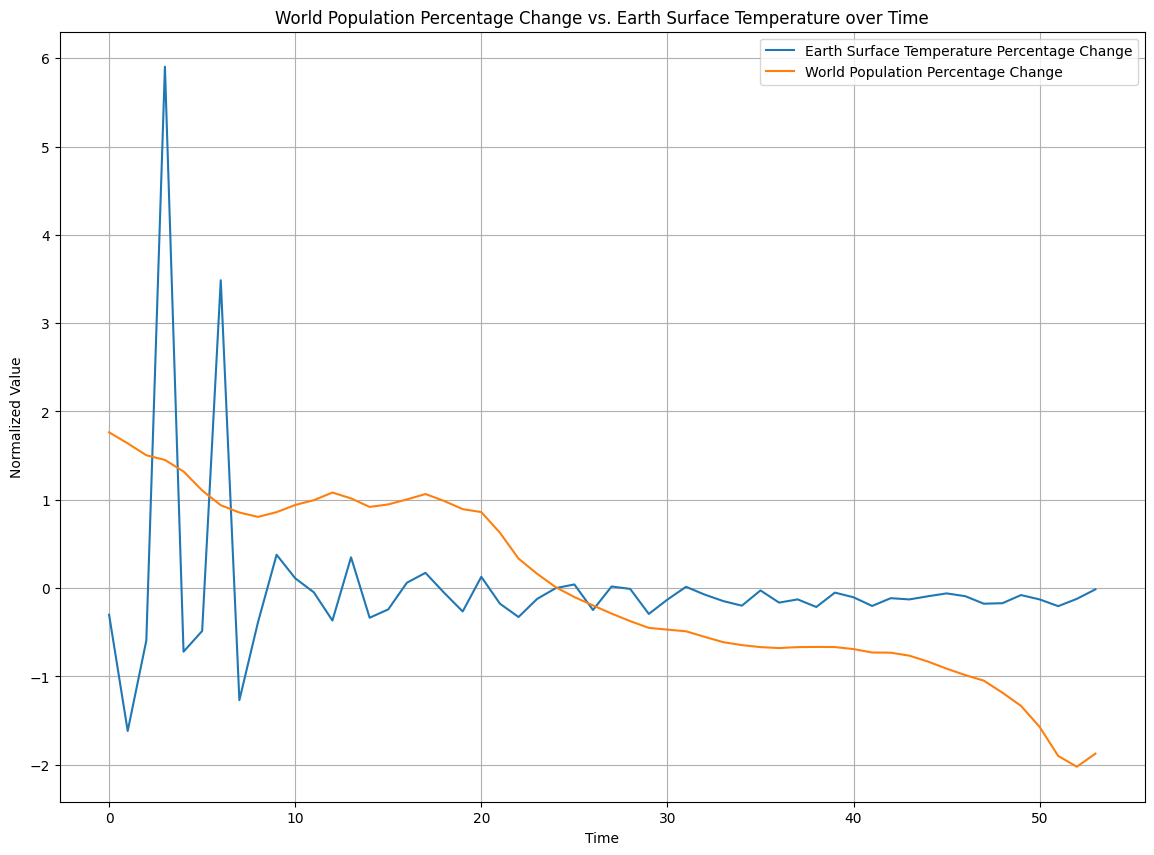

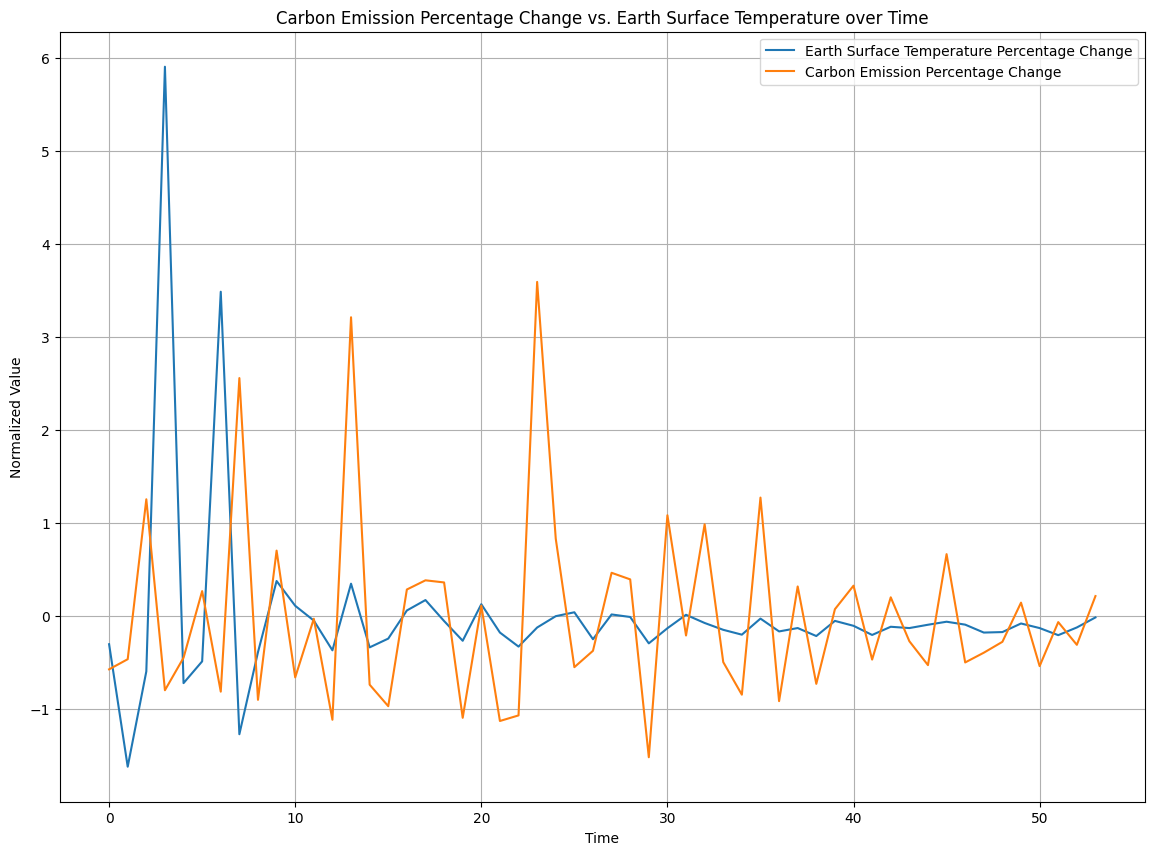

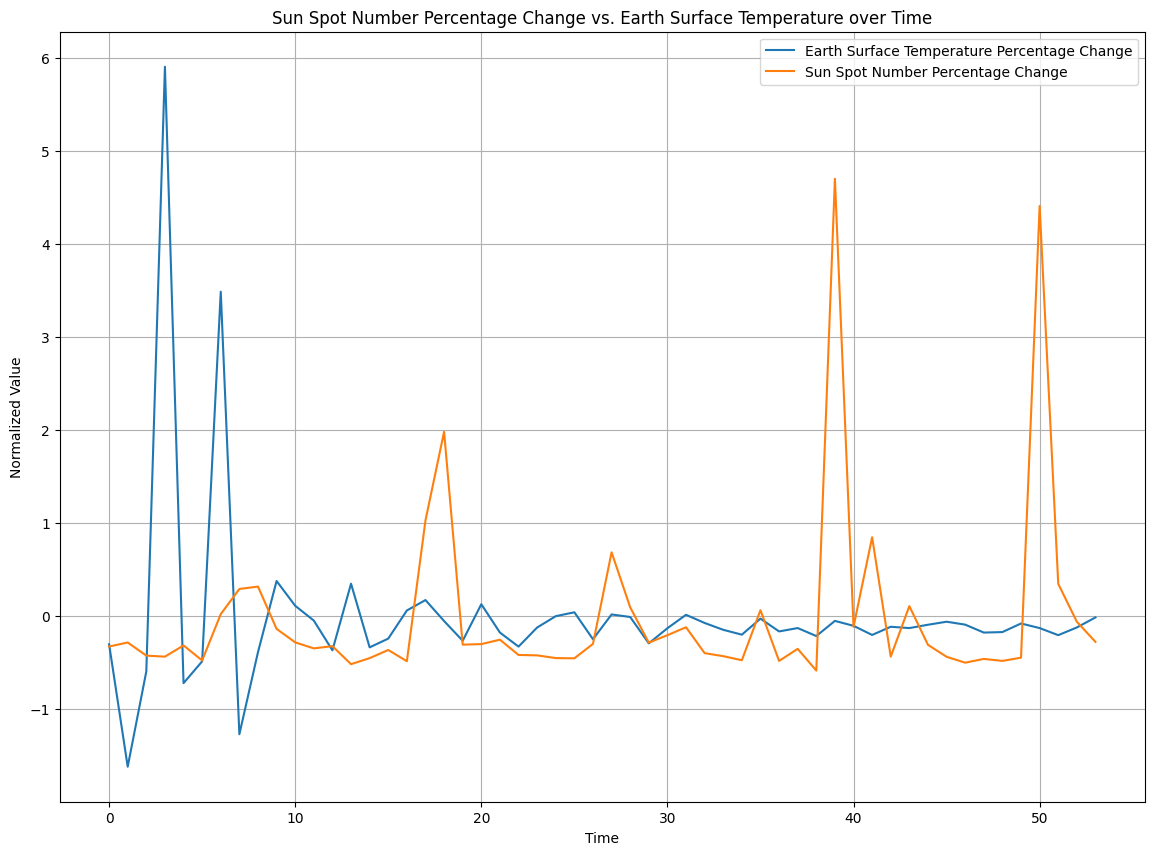

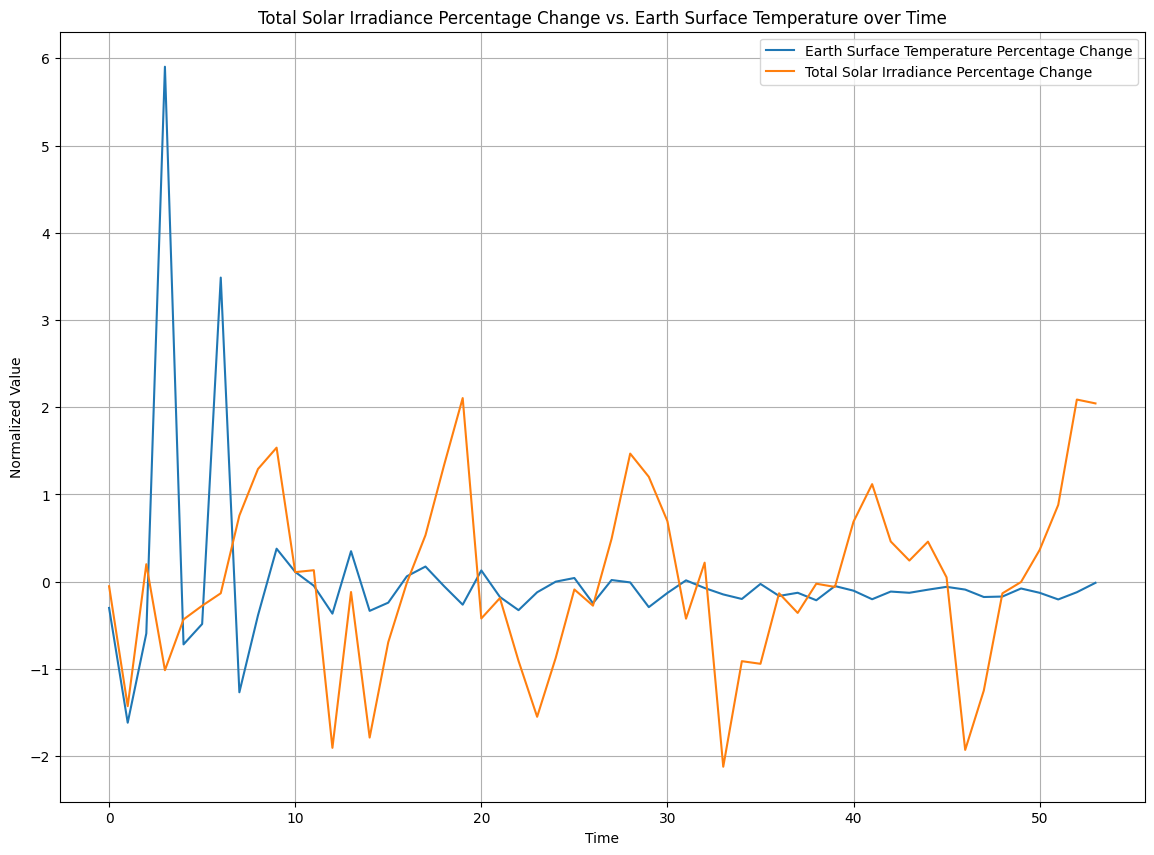

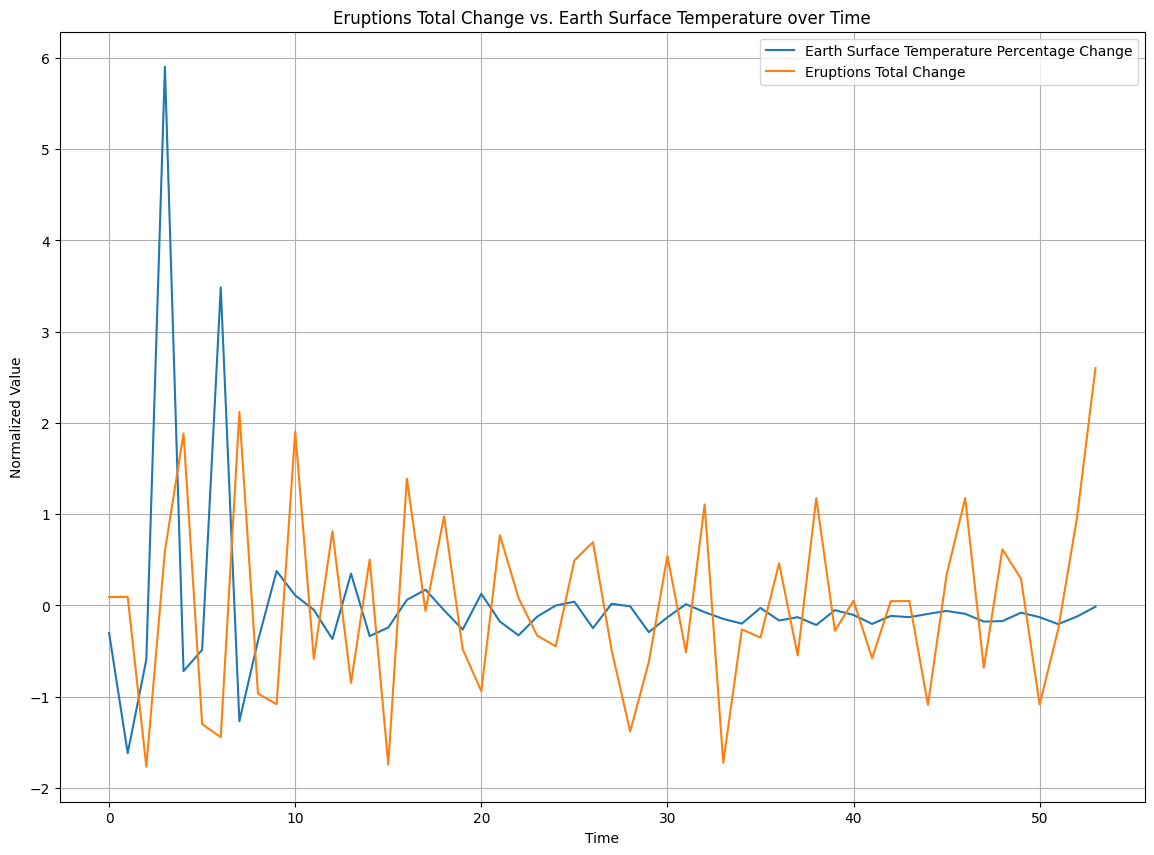

In [38]:
import matplotlib.pyplot as plt
# Convert normalized_df back to a DataFrame with column names and the original index for plotting pre-processing
normalized_df = pd.DataFrame(normalized_df, columns=combined_df.columns, index=combined_df.index)
# Plotting individual time-series plots for each columns' Percentage Change against the Percentage Change of Earths' surface temperature
target_column = 'Earth Surface Temperature Percentage Change'
# Plot each column against 'Earth Surface Temperature Percentage Change'
columns_to_plot = normalized_df.columns.drop(target_column)
for column in columns_to_plot:
    plt.figure(figsize=(14, 10))
    plt.plot(combined_df.index, normalized_df[target_column], label='Earth Surface Temperature Percentage Change')
    plt.plot(combined_df.index, normalized_df[column], label=column)
    plt.xlabel('Time')
    plt.ylabel('Normalized Value')
    plt.title(f'{column} vs. Earth Surface Temperature over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

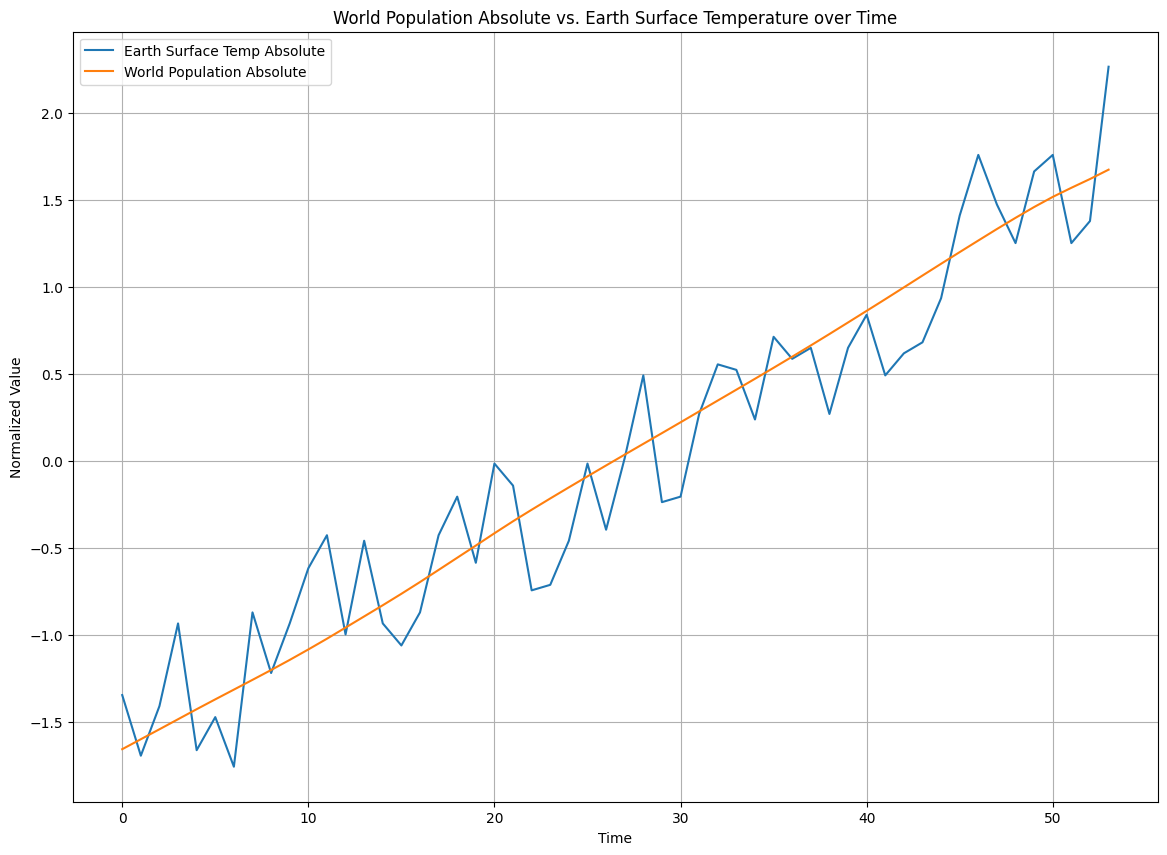

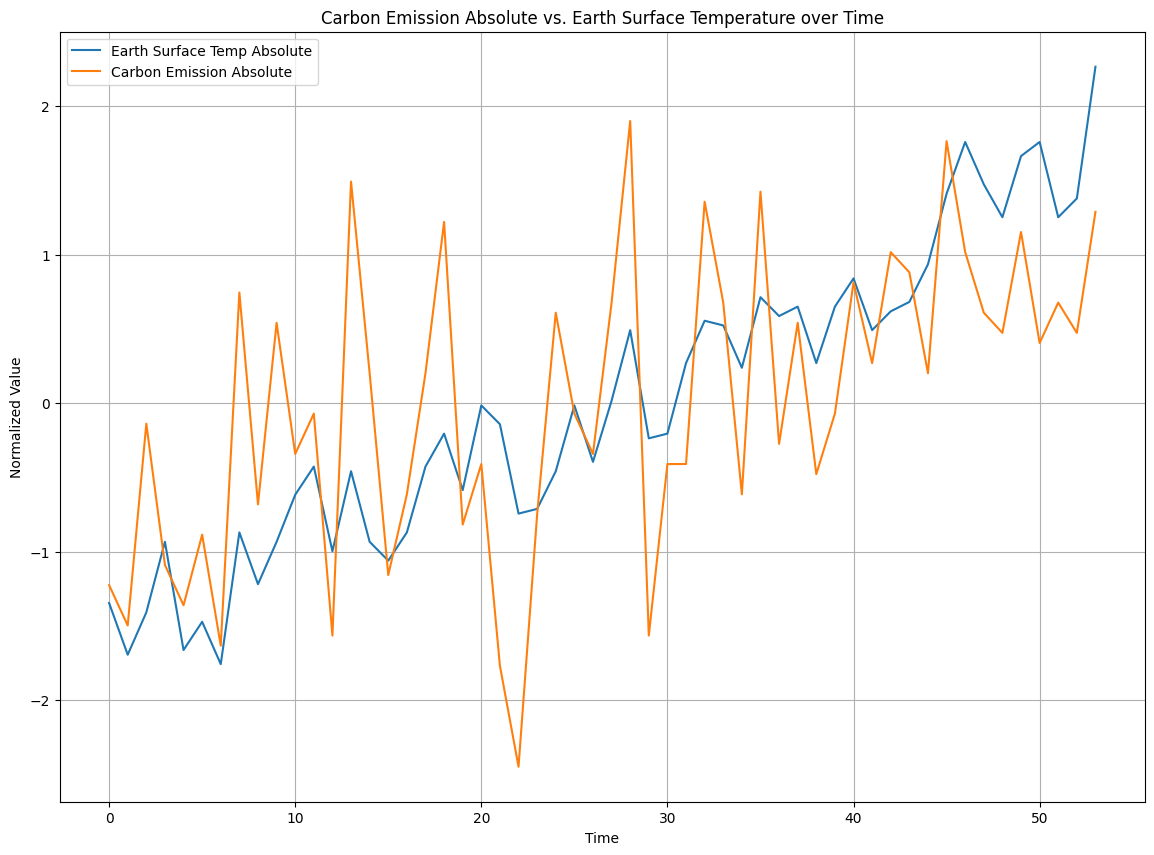

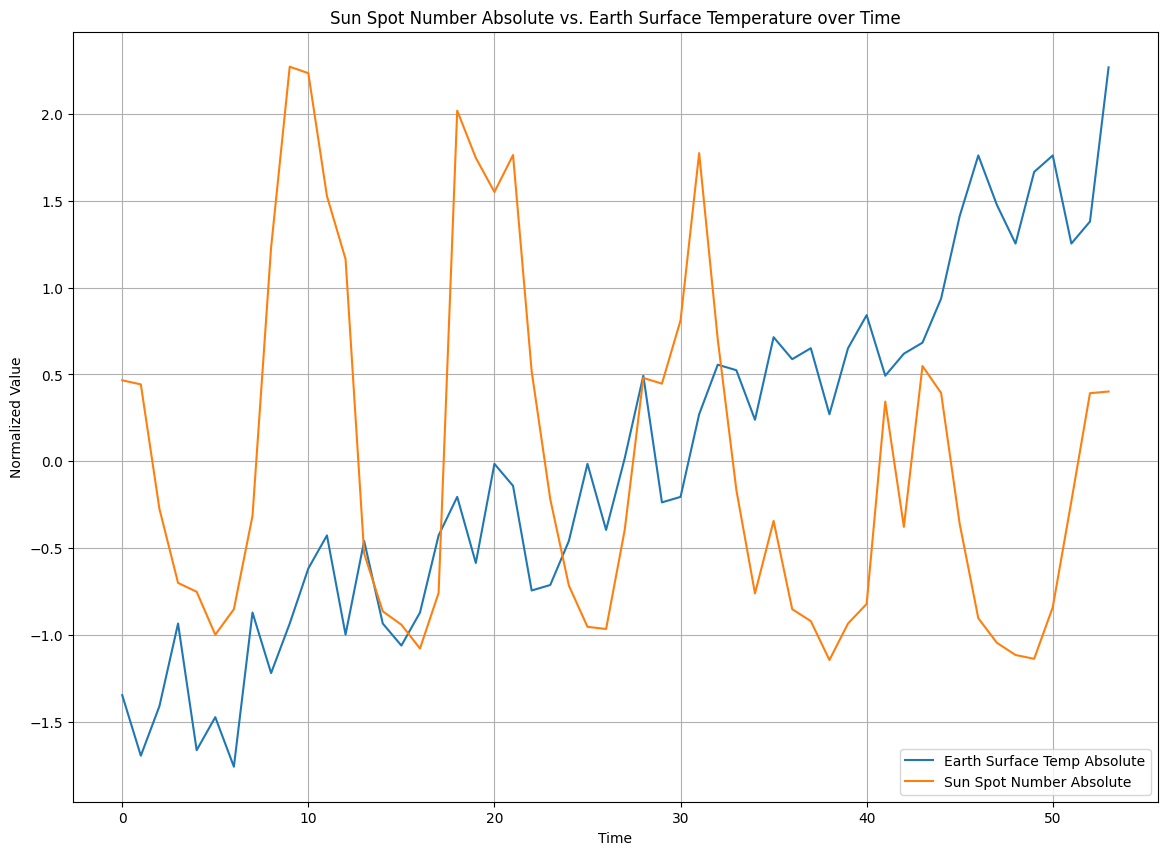

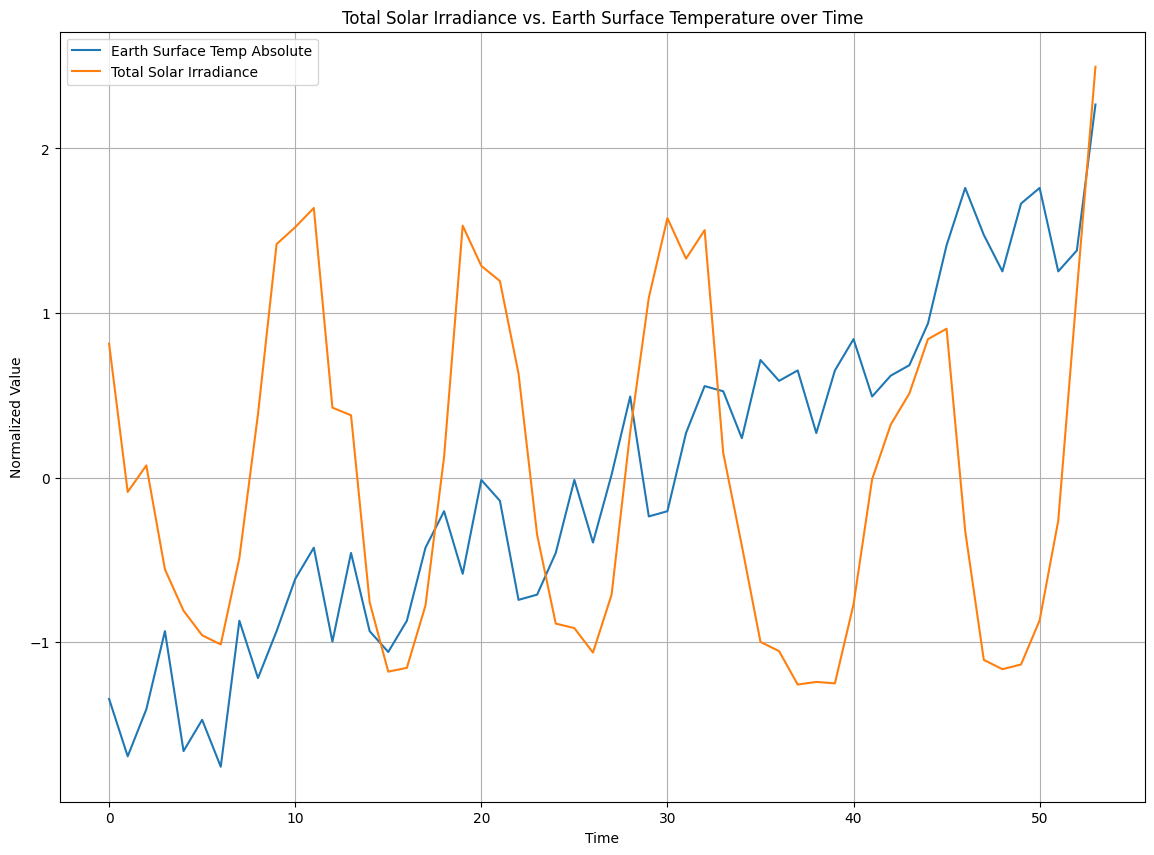

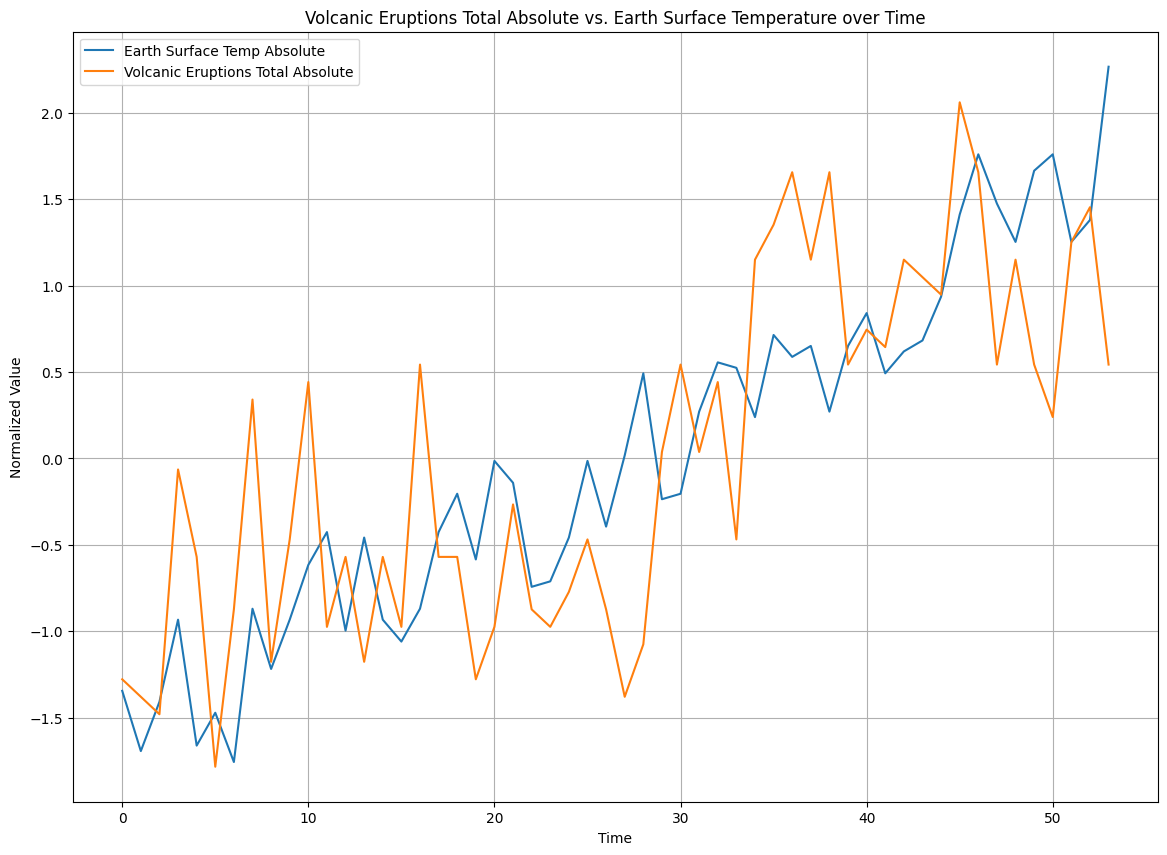

In [42]:
# Convert normalized_df2 back to a DataFrame with column names and the original index
normalized_df2 = pd.DataFrame(normalized_df2, columns=combined_df2.columns, index=combined_df2.index)
# Plotting individual time-series plots for each columns' absolute values against the absolute values of Earths' surface temperature
target_column2 = 'Earth Surface Temp Absolute'

# Plot each column against the absolute values of the Earths' Surface Temperature
columns_to_plot2 = normalized_df2.columns.drop(target_column2)

for column in columns_to_plot2:
    plt.figure(figsize=(14, 10))
    plt.plot(combined_df2.index, normalized_df2[target_column2], label='Earth Surface Temp Absolute')
    plt.plot(combined_df2.index, normalized_df2[column], label=column)

    plt.xlabel('Time')
    plt.ylabel('Normalized Value')
    plt.title(f'{column} vs. Earth Surface Temperature over Time')
    plt.legend()
    plt.grid(True)
    plt.show()